<a href="https://colab.research.google.com/github/guthi1/deep-learning/blob/main/Cours%20Courville/generative_model/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6135-A2022
# Assignment 3: GAN Practical

You must fill in your answers to various questions in this notebook, following which you must export this notebook to a Python file named `gan.py` and submit it on Gradescope.

**Make sure you request a GPU runtime!**

## GAN Basics

Generative Adversarial Autoencoders are generative models that are popularly used for unsupervised learning and are aimed at solving a two-player zero-sum game where a generator model is used to produce realistic samples which can fool a discriminator, which is tasked with distinguishing between real and fake samples. 

The formal objective for GANs can be seen as

\begin{align*}
\min_G \max_D \mathbb{E}_{x\sim p_{data}} [\log D(x)] + \mathbb{E}_{z\sim p_z} [\log (1 - D(G(z))]
\end{align*}

Where we can see that the job of the discriminator is to distinguish between data coming from the real distribution $x_{real} \sim p_{data}$ and the data that is being generated by the generator $x_{fake} = G(z)$ where $z\sim p_z$, where $p_z$ is just some prior distribution, often kept as $\mathcal{N}(0, I)$. One can see the objective for $D(\cdot)$ through the lens of classification, and in particular through the binary cross entropy loss.

On the other hand, once the discriminator is trained to optimality, the job of the generator (the outer $\min$) is to generate samples that fool the discriminator. In practice, instead of training the discriminator to optimality, we just alternate between training the discriminator for one step, and then the generator for one step, and we keep alternating. Further, the objective for the generator leads to poor gradient properties, and hence for training of the generator we aim to instead maximize

\begin{align*}
\mathbb{E}_{z\sim p_z} [\log D(G(z))]
\end{align*}

Note that in both the equations, $G(z)$ is optimal only if it is able to fool the discriminator.

For details about GANs, please refer to [Goodfellow's Paper](https://arxiv.org/abs/1406.2661).

In [ ]:
# !pip install -q -U datasets matplotlib==3.1.1 tqdm

import random
import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms

from pathlib import Path
from torch.utils.data import DataLoader

def fix_experiment_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_experiment_seed()

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Set up the hyperparameters
- Batch Size
- Latent Dimensionality
- Learning Rate

In [ ]:
# Training Hyperparameters
batch_size = 64   # Batch Size
z_dim = 32        # Latent Dimensionality
gen_lr = 1e-4     # Learning Rate for the Generator
disc_lr = 1e-4    # Learning Rate for the Discriminator

In [ ]:
# Define Dataset Statistics
image_size = 32
input_channels = 3

# Resize and Normalize the Data
transform = Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# Helper Functions
def show_image(image, nrow=8):
  # Input: image
  # Displays the image using matplotlib
  grid_img = make_grid(image.detach().cpu(), nrow=nrow, padding=0)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')

def transforms_examples(examples):
  # Helper function to perform transformations on the input images
  if "image" in examples:
     examples["pixel_values"] = [transform(image) for image in examples["image"]]
     del examples["image"]
  else:
     examples["pixel_values"] = [transform(image) for image in examples["img"]]
     del examples["img"]

  return examples

In [ ]:
# Load dataset from the hub, normalize it and create the dataloader
def get_dataloaders():
  dataset = load_dataset("svhn", 'cropped_digits', cache_dir='./data')
  transformed_dataset = dataset.with_transform(transforms_examples)
  train_dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True, drop_last=True)
  test_dataloader = DataLoader(transformed_dataset["test"], batch_size=batch_size, shuffle=False, drop_last=False)
  return train_dataloader, test_dataloader

## Visualize the Data

Lets visualize what our data actually looks like! We are using the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/) which comprises of images of house numbers seen from the streets.

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([64, 3, 32, 32])


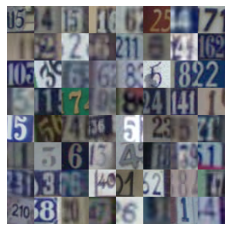

In [ ]:
# Visualize the Dataset
def visualize():
  train_dataloader, _ = get_dataloaders()
  batch = next(iter(train_dataloader))
  print(batch['pixel_values'].shape)

  save_image((batch['pixel_values'] + 1.) * 0.5, './results/orig.png')
  show_image((batch['pixel_values'] + 1.) * 0.5)

if __name__ == '__main__':
  visualize()

## Define the Model Architectures

For a GAN model, we need two architectures, one for the Generator and the other for the discriminator. The generator a sample from $\mathcal{N}(0, I)$ to the input space (which is the pixel space), while the discriminator maps a sample in the input space to a scalar, which determines (after a sigmoid) the probability of the input being from the real distribution.

The architectures for both the generator and the discriminator networks have been provided to you for ease of experimentation. You are welcome to play with the architecture and change it for exploration purposes, but please stick to this architecture for the purpose of this homework.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class Generator(nn.Module):
    def __init__(self, z_dim, channels, generator_features=32):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, generator_features * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_features * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(generator_features * 4, generator_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( generator_features * 2, generator_features * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features * 1),
            nn.ReLU(True),
            nn.ConvTranspose2d( generator_features * 1, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.z_dim = z_dim
        self.apply(weights_init)

    def forward(self, input):
        return self.model(input)

class Discriminator(nn.Module):
    def __init__(self, channels, discriminator_features=32):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, discriminator_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_features, discriminator_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_features * 2, discriminator_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_features * 4, 1, 4, 1, 0, bias=False),
        )

        self.apply(weights_init)

    def forward(self, input):
        return self.model(input)

Next, we define both the generator and the discriminator networks.

In [ ]:
generator = Generator(z_dim, input_channels).to(device)
discriminator = Discriminator(input_channels).to(device)

## Set the optimizers for each model

Your task is to set each optimizer to be the Adam optimizer with the corresponding parameters, the learning rates kept as disc_lr and gen_lr respectively, and the betas hyperparameter set as (0.5, 0.999). You can use PyTorch's in-built Adam optimizer.


In [ ]:
discriminator_optimizer = Adam(discriminator.parameters(), lr=disc_lr, betas=(0.5, 0.999))
generator_optimizer = Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))        

## Define the criterion required for training.

Your task is to identify the objective as a binary cross entropy objective and fill in the corresponding criterion. It should take as input un-normalized probabilities (without the sigmoid) and the true labels, and return the averaged loss. You can use one of PyTorch's in-built criterions.

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

## Define the Training functions for the discriminator and the generator

Now, we need training scripts to run one step of discriminator training and one step of generator training respectively. In particular, the task is to fill the following functions:

- discriminator_train: The function takes as input a set of real samples and a set of fake samples, and is supposed to return the average loss for training of the discriminator. To recap, the objective for the discriminator is $\max_D \sum\limits_{i=1}^N \log D(x_i) + \sum\limits_{i=1}^N \log (1 - D(G(z_i))$, where minimization implies just taking negative of the objective. Here $x_i$ are the real samples while $z_i$ are noise samples used to generate fake samples.

- generator_train: The function takes as input a set of fake samples and is supposed to return the average loss for training of the generator. To recap, the objective for the generator is $\max_G \sum\limits_{i=1}^N \log D(G(z_i))$, where minimization implies just taking negative of the objective. Here $z_i$ are noise samples used to generate fake samples.

In [ ]:
def discriminator_train(discriminator, generator, real_samples, fake_samples):
  # Takes as input real and fake samples and returns the loss for the discriminator
  # Inputs:
  #   real_samples: Input images of size (batch_size, 3, 32, 32)
  #   fake_samples: Input images of size (batch_size, 3, 32, 32)
  # Returns:
  #   loss: Discriminator loss

  ones = torch.ones(real_samples.size(0)).to(device)   
  zeros = torch.zeros(fake_samples.size(0)).to(device)   

  real_output = discriminator(real_samples)    
  fake_output = discriminator(fake_samples)    

  loss = criterion(real_output.squeeze(), ones) + criterion(fake_output.squeeze(), zeros)           

  return loss

def generator_train(discriminator, generator, fake_samples):
  # Takes as input fake samples and returns the loss for the generator
  # Inputs:
  #   fake_samples: Input images of size (batch_size, 3, 32, 32)
  # Returns:
  #   loss: Generator loss

  ones = torch.ones(fake_samples.size(0)).to(device)   
  output = discriminator(fake_samples) 
  loss = criterion(output.squeeze(), ones)    

  return loss

def sample(generator, num_samples):
  # Takes as input the number of samples and returns that many generated samples
  # Inputs:
  #   num_samples: Scalar denoting the number of samples
  # Returns:
  #   samples: Samples generated; tensor of shape (num_samples, 3, 32, 32)

  with torch.no_grad():
    noise = torch.randn(num_samples, generator.z_dim, 1, 1, device=device)
    return generator(noise)


Finally, let's start training!
Visualization of the samples generated, the original dataset and the reconstructions are saved locally in the notebook!

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

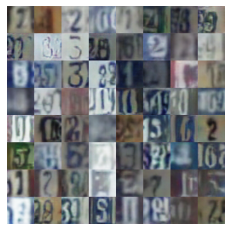

In [ ]:
epochs = 25

if __name__ == '__main__':
  train_dataloader, _ = get_dataloaders()
  for epoch in range(epochs):
    with tqdm(train_dataloader, unit="batch", leave=False) as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Epoch: {epoch}")

        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake = generator(noise)
        real = batch['pixel_values'].to(device)

        discriminator.zero_grad()
        disc_loss = discriminator_train(discriminator, generator, real, fake.detach())
        disc_loss.backward()
        discriminator_optimizer.step()

        generator.zero_grad()
        gen_loss = generator_train(discriminator, generator, fake)
        gen_loss.backward()
        generator_optimizer.step()

        tepoch.set_postfix(disc_loss=disc_loss.item(), gen_loss=gen_loss.item())

    samples = sample(generator, 64)
    save_image((real + 1.) * 0.5, './results/orig.png')
    save_image((samples + 1.) * 0.5, f'./results/samples_{epoch}.png')

  show_image((samples + 1.) * 0.5)

We can also visualize the interpolation between two points in the latent space: $z_1$ and $z_2$ by choosing points at equal intervals on the line from the two points.

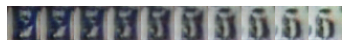

In [ ]:
def interpolate(generator, z_1, z_2, n_samples):
  # Interpolate between z_1 and z_2 with n_samples number of points, with the first point being z_1 and last being z_2.
  # Inputs:
  #   z_1: The first point in the latent space
  #   z_2: The second point in the latent space
  #   n_samples: Number of points interpolated
  # Returns:
  #   sample: A sample from the generator obtained from each point in the latent space
  #           Should be of size (n_samples, 3, 32, 32)
  lengths = torch.linspace(0., 1., n_samples).unsqueeze(1).to(device)
#   delta = z_2 - z_1
#   grad = torch.einsum('b a, a z n m -> b z n m', lengths, delta)
#   z = z_1 + grad 
  z = torch.lerp(z_2, z_1, lengths)
  return generator(z.transpose(0,2))

if __name__ == '__main__':
  z_1 = torch.randn(1, z_dim, 1 ,1).to(device)
  z_2 = torch.randn(1, z_dim, 1, 1).to(device)

  interp = interpolate(generator, z_1, z_2, 10)
  show_image((interp + 1.) * 0.5, nrow=10)